In [1]:
import keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation

Using Theano backend.


In [2]:
import numpy as np

In [3]:
from keras import backend as K

In [4]:
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix

class MultiGraph:
    def __init__(self):
        self.n_nodes = 0
        self.n_rels = 0
        self.nodes = {}
        self.rels = {}
        self.node_labels = []
        self.rel_labels = []
        self.sparse_graph = {} #{relation: [row, col, data]}
        self.rel_counter = Counter()
    
    def add_connection(self, connection):
        # connection is (source, relation, target)
        src,rel,targ = connection
        #add new nodes and relations to dictionaries
        if src not in self.nodes.keys():
            self.nodes[src] = self.n_nodes
            self.node_labels.append(src)
            self.n_nodes += 1
        if targ not in self.nodes.keys():
            self.nodes[targ] = self.n_nodes
            self.node_labels.append(targ)
            self.n_nodes += 1
        if rel not in self.rels.keys():
            self.rels[rel] = self.n_rels
            self.rel_labels.append(rel)
            self.n_rels += 1
            self.sparse_graph[self.rels[rel]] = [[],[],[]] #{relation: [row, col, data]}
        #count number of relations
        self.rel_counter.update({rel: 1})
        # add new connection to graph
        self.sparse_graph[self.rels[rel]][0].append(self.nodes[src])
        self.sparse_graph[self.rels[rel]][1].append(self.nodes[targ])
        self.sparse_graph[self.rels[rel]][2].append(1)
    
    def get_adjacency_matrix(self):
        #iterleave all the columns from the individual adjacency matrices
        #it is an out-going adjacency graph
        full_matrix = [[],[],[]]
        for k in range(self.n_rels):
            full_matrix[0].extend(self.sparse_graph[k][0])
            #shift the column index to fit the added relation 
            col_shift = [i*self.n_rels+k for i in self.sparse_graph[k][1]]
            full_matrix[1].extend(col_shift)
            full_matrix[2].extend(self.sparse_graph[k][2])
        shape = (self.n_nodes,self.n_nodes*self.n_rels)
        return csr_matrix((full_matrix[2], (full_matrix[0],full_matrix[1])), shape=shape, dtype=np.float32)
    
    def get_adjacency_matrix_k(self,k):
        #it is an out-going adjacency graph of relation k
        graph_k = self.sparse_graph[self.rels[k]]
        shape = (self.n_nodes,self.n_nodes)
        return csr_matrix((graph_k[2], (graph_k[0],graph_k[1])), shape=shape, dtype=np.float32)
    
    def get_node_label(self,index):
        return self.node_labels[index]
    
    def get_relation_label(self,index):
        return self.rel_labels[index]
    
    def get_relation_counter(self):
        return self.counter

In [5]:
#import csv
import unicodecsv as csv
""" EXAMPLE
add,IS,operator
subtract,IS,operator
multiply,IS,operator
divide,IS,operator
open_closure,IS,operator
close_closure,IS,operator
"""
op_graph = MultiGraph()
#with open('operator_graph.csv', 'r') as csvfile:
for i in range(45):
    print('loading relation '+str(i)+'...')
    with open('aifb_csv/aifb_relation_'+str(i)+'.csv', 'r') as csvfile:
        graphreader = csv.reader(csvfile)
        for row in graphreader:
            #print(row)
            op_graph.add_connection(row)

loading relation 0...
loading relation 1...
loading relation 2...
loading relation 3...
loading relation 4...
loading relation 5...
loading relation 6...
loading relation 7...
loading relation 8...
loading relation 9...
loading relation 10...
loading relation 11...
loading relation 12...
loading relation 13...
loading relation 14...
loading relation 15...
loading relation 16...
loading relation 17...
loading relation 18...
loading relation 19...
loading relation 20...
loading relation 21...
loading relation 22...
loading relation 23...
loading relation 24...
loading relation 25...
loading relation 26...
loading relation 27...
loading relation 28...
loading relation 29...
loading relation 30...
loading relation 31...
loading relation 32...
loading relation 33...
loading relation 34...
loading relation 35...
loading relation 36...
loading relation 37...
loading relation 38...
loading relation 39...
loading relation 40...
loading relation 41...
loading relation 42...
loading relation 43..

In [6]:
a_graph = op_graph.get_adjacency_matrix()
print("number of nodes",op_graph.n_nodes)
print("number of relations",op_graph.n_rels)
#print("node labels",op_graph.node_labels)
print(op_graph.rel_counter)

('number of nodes', 8284)
('number of relations', 45)
Counter({u'http://swrc.ontoware.org/ontology#publication': 4163, u'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': 4124, u'http://swrc.ontoware.org/ontology#author': 3986, u'http://swrc.ontoware.org/ontology#isAbout': 2477, u'http://swrc.ontoware.org/ontology#name': 1302, u'http://swrc.ontoware.org/ontology#year': 1227, u'http://swrc.ontoware.org/ontology#title': 1227, u'http://swrc.ontoware.org/ontology#publishes': 1217, u'http://swrc.ontoware.org/ontology#projectInfo': 952, u'http://swrc.ontoware.org/ontology#hasProject': 952, u'http://swrc.ontoware.org/ontology#booktitle': 765, u'http://swrc.ontoware.org/ontology#month': 759, u'http://swrc.ontoware.org/ontology#isWorkedOnBy': 571, u'http://swrc.ontoware.org/ontology#pages': 548, u'http://swrc.ontoware.org/ontology#abstract': 534, u'http://swrc.ontoware.org/ontology#dealtWithIn': 357, u'http://swrc.ontoware.org/ontology#member': 339, u'http://swrc.ontoware.org/ontology#volume': 

In [7]:
x_train = a_graph
print('input dims:',x_train.shape)
print(type(x_train))
sum(list(x_train[5]))

('input dims:', (8284, 372780))
<class 'scipy.sparse.csr.csr_matrix'>


<1x372780 sparse matrix of type '<type 'numpy.float32'>'
	with 18 stored elements in Compressed Sparse Row format>

In [8]:
encoding_dim = 128
input_dim = x_train.shape[1]

inputs = Input(shape=(input_dim,))
# Encoder Layers
encoding_1 = Dense(4 * encoding_dim, activation='relu',name="encoding_1")(inputs)
encoding_2 = Dense(2 * encoding_dim, activation='relu',name="encoding_2")(encoding_1)
the_code = Dense(encoding_dim, activation='relu',name="the_code")(encoding_2)
# Decoder Layers
decoding_1 = Dense(4 * encoding_dim, activation='relu',name="decoding_1")(the_code)
decoding_2 = Dense(2 * encoding_dim, activation='relu',name="decoding_2")(decoding_1)
reconstruction = Dense(input_dim, activation='sigmoid',name="reconstruction")(decoding_2)

ae = Model(inputs=inputs, outputs=reconstruction)
#monitor = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
ae.compile(optimizer='adam', loss='mse')
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 372780)            0         
_________________________________________________________________
encoding_1 (Dense)           (None, 512)               190863872 
_________________________________________________________________
encoding_2 (Dense)           (None, 256)               131328    
_________________________________________________________________
the_code (Dense)             (None, 128)               32896     
_________________________________________________________________
decoding_1 (Dense)           (None, 512)               66048     
_________________________________________________________________
decoding_2 (Dense)           (None, 256)               131328    
_________________________________________________________________
reconstruction (Dense)       (None, 372780)            95804460  
Total para

In [9]:
ae.fit(x_train, x_train.toarray(), epochs=2, batch_size=64, verbose=1)

Epoch 1/2
8284/8284 [==============================] - 503s 61ms/step - loss: 0.0766
Epoch 2/2
8284/8284 [==============================] - 340s 41ms/step - loss: 9.4048e-06


In [10]:
#coding_model = Model(inputs=ae.inputs, outputs=ae.get_layer("the_code").output)
coding_model = Model(inputs=inputs, outputs=the_code)
embedding = coding_model.predict(x_train)

In [11]:
for i in range(min(10,len(embedding))):
    print str(op_graph.get_node_label(i))+' : '+str(list(embedding[i]))

http://www.aifb.uni-karlsruhe.de/Publikationen/viewExternerAutorOWL/id527instance : [0.0, 3.3579674, 0.0, 2.7466092, 2.7927978, 0.0, 3.4017599, 3.2008116, 3.105305, 0.0, 4.1088223, 3.8181198, 0.0, 0.0, 3.0560617, 0.0, 0.0, 0.0, 4.5810704, 2.1783965, 3.3866053, 1.5769895, 4.381891, 3.3455482, 2.9443798, 2.489079, 4.5671096, 3.1865525, 0.0, 0.015334446, 0.0, 2.7729557, 3.43277, 0.0, 0.0, 4.6002455, 3.553073, 0.0, 3.2710707, 3.2700586, 3.4333606, 0.0, 0.0, 0.0, 2.500885, 0.0, 3.713538, 2.8021107, 5.3140326, 1.9238, 2.9361563, 0.0, 0.0, 5.1350513, 0.0, 4.2357173, 0.0, 4.0434346, 0.0, 0.0, 0.0, 0.0, 3.1530426, 3.5321827, 5.0770764, 2.3343468, 0.0, 3.306006, 2.4625173, 1.9943364, 2.9362886, 2.055381, 4.186167, 0.0, 0.0, 0.0, 0.0, 3.585422, 0.0, 0.0, 1.6199834, 0.0, 1.6091275, 3.8882563, 2.9709918, 0.0, 3.8310072, 4.4554415, 0.0, 0.0, 2.7299716, 0.0, 0.0, 2.0760474, 2.3110225, 0.0, 0.0, 0.0, 0.0, 3.7495232, 3.0708306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.300615, 0.0, 0.0, 3.496653, 3.9407227, 0.0,

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gensim

#from https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(vectors):
    
    vector_labels = [op_graph.get_node_label(i).rsplit('/', 1)[-1] for i in range(len(vectors))]
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords)
    

    for label, x, y in zip(vector_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

def pcascatterplot(vectors):
    
    vector_labels = [op_graph.get_node_label(i).rsplit('/', 1)[-1] for i in range(len(vectors))]
        
    # find tsne coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords)
    

    for label, x, y in zip(vector_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [13]:
ran_indices = np.random.choice(len(embedding), 1000,replace=False)

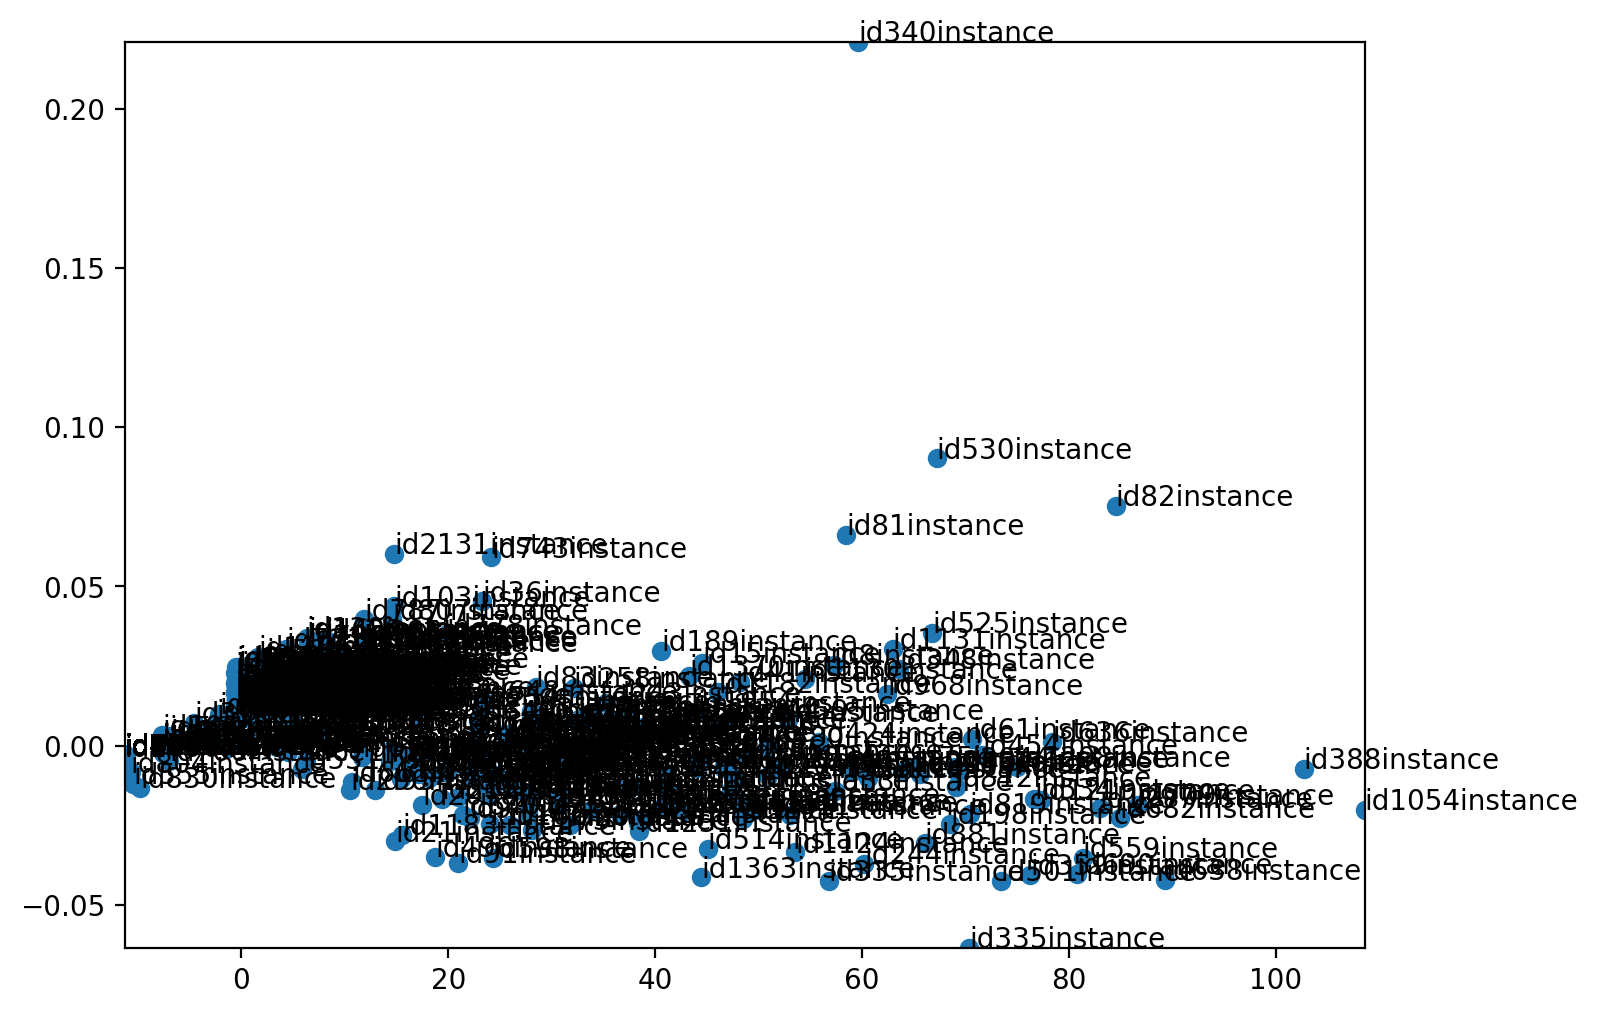

In [14]:
pcascatterplot([embedding[i] for i in ran_indices])

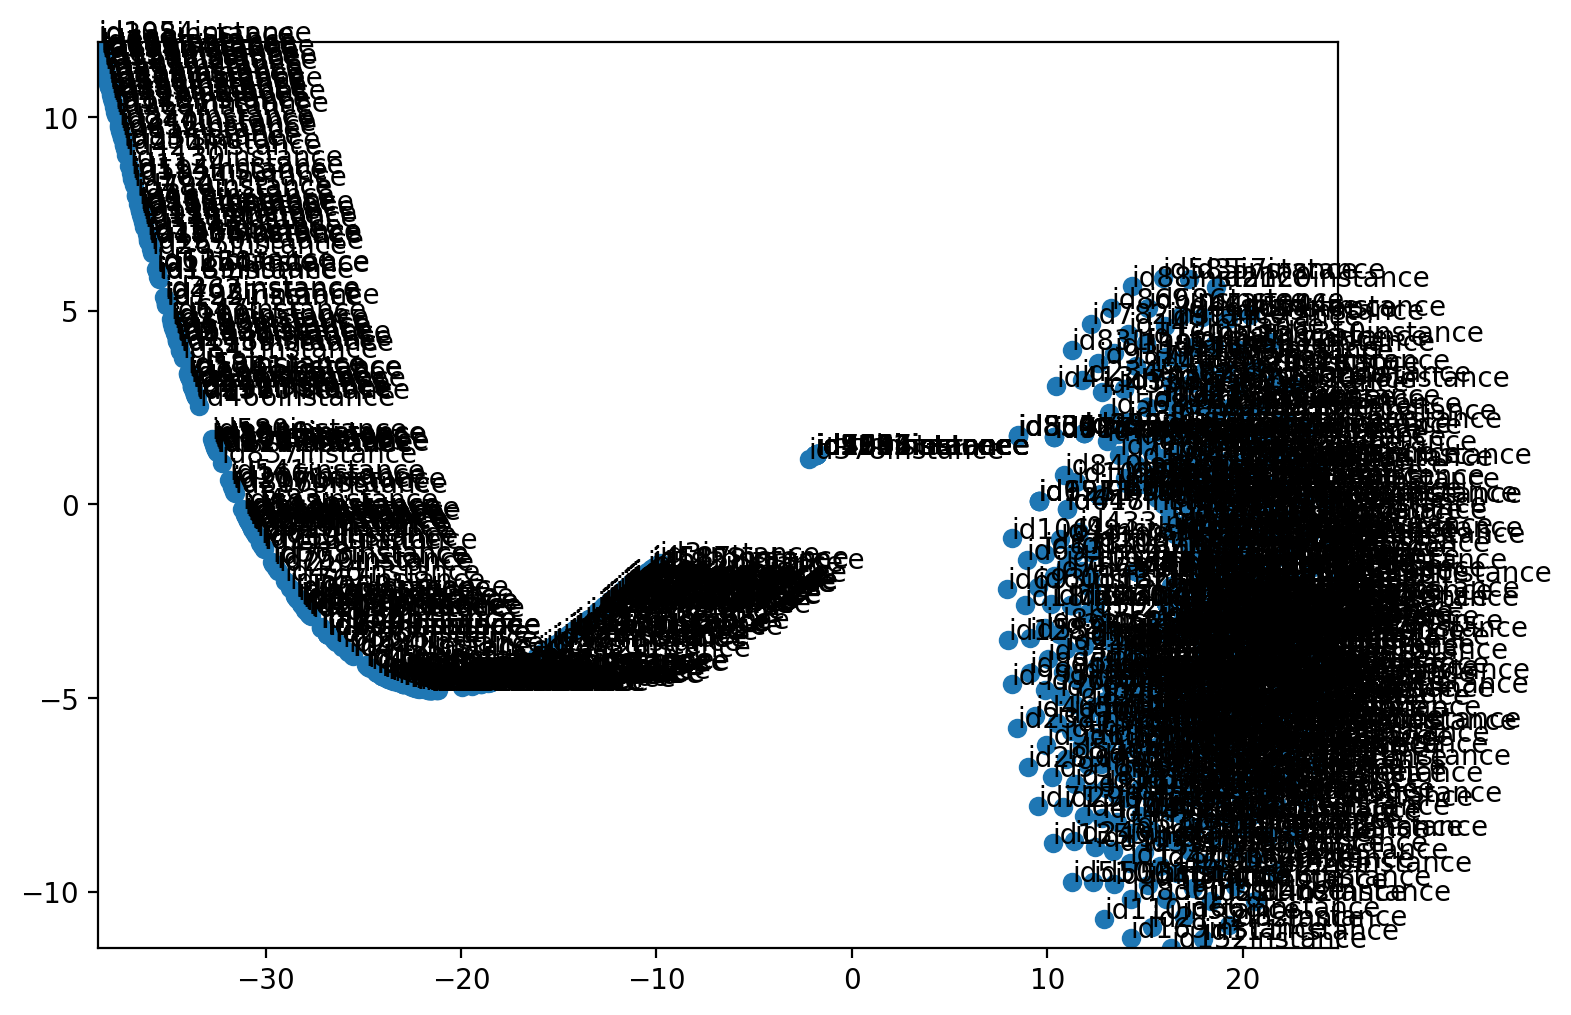

In [15]:
tsnescatterplot([embedding[i] for i in ran_indices])

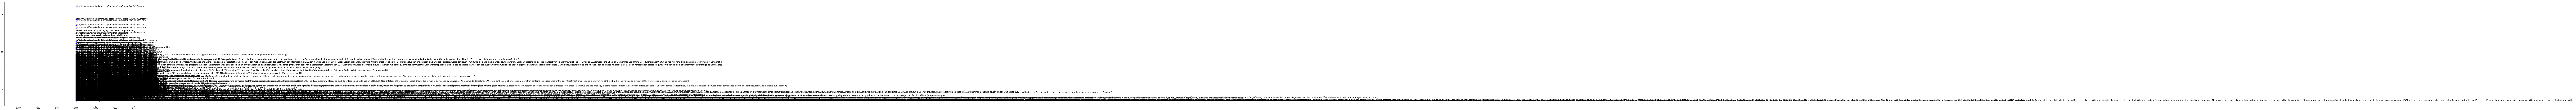

In [16]:
fig = plt.figure(figsize=(16, 12))
#ax = fig.add_subplot(111, projection='2d')
ax = fig.add_subplot(111)
for i in range(len(embedding)):
    ax.scatter(embedding[i,0],embedding[i,1],color='b') 
    ax.text(embedding[i,0],embedding[i,1],  '%s' % (op_graph.get_node_label(i)), size=12, zorder=1, color='k') 